# Beta-Variational autoencoder


Get your solution for Exercise 1 and restart runtime.

Add beta parameter.

Experiment with different values of beta parameter, compare the results.

Install the correct version of TensorFlow

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.14

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.1 MB/s eta 0:00:00
  Att

Import all the libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import backend as K

## Data

Load MNIST dataset

In [ ]:
def load_mnist():
  # load
  mnist_dataset = mnist.load_data()
  (trainset, testset) = (mnist_dataset[0], mnist_dataset[1])
  (X_train, y_train) = trainset
  (X_test, y_test) = testset
  # preprocess
  X_train = X_train.astype('float32')
  X_train /= 255
  X_test = X_test.astype('float32')
  X_test /= 255
  # Flatten - VAE will be made as fully-connected network
  X_train_fl = X_train.reshape(X_train.shape[0], np.prod(X_train.shape[1:]))
  X_test_fl = X_test.reshape(X_test.shape[0], np.prod(X_test.shape[1:]))
  return X_train_fl, y_train, X_test_fl, y_test

In [ ]:
X_train, y_train, X_test, y_test = load_mnist()

Show data

In [ ]:
def show_images(X, n_images=4):
  fig = plt.figure()
  for i in range(n_images):
    fig.add_subplot(1, n_images, i+1)
    X_plot = X[i].reshape((28,28))
    plt.imshow(X_plot, cmap='gray')
  plt.show()

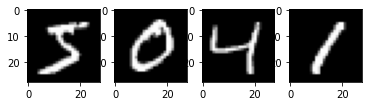

In [ ]:
show_images(X_train, n_images=4)

## Model

Network parameters

In [ ]:
input_size = 28*28
optimizer = 'adam'
batch_size=128
epochs=50

input_shape = (input_size, )
intermediate_dim = 100
latent_dim = 2

##### NEW #######
beta = 2.0
#################

Build encoder model.



In [ ]:
inputs = Input(shape=input_shape, name='encoder_input')
intermediate_enc = Dense(intermediate_dim, activation='relu')(inputs)
# last encoding layer should output parameters of the Gaussian distribution - mean and variance
z_mean = Dense(latent_dim, name='z_mean')(intermediate_enc)
z_log_var = Dense(latent_dim, name='z_log_var')(intermediate_enc)  # this is the natural logarithm of the variance (log(sigma^2))

Sampling function and Lambda layer

In [ ]:
# function for sampling from the learned distribution

# Sample epsilon = N(0,I)
# Put epsilon to the learned distribution
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.math.exp(0.5 * z_log_var) * epsilon

# Lambda layer - use user-defined function as a Keras layer
from keras.layers import Lambda
z = Lambda(sampling, name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

Build decoder model

In [ ]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
intermediate_dec = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(input_size, activation='sigmoid')(intermediate_dec)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
# connect encoder and decoder
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Make custom loss - MSE + KL

In [ ]:
# Loss - MSE + KL divergence
from keras.losses import mse

reconstruction_loss = mse(inputs, outputs)
# MSE is mean over dimensions, and KL loss is sum over dimensions
# Therefore, we need to multiply MSE by the number of dimensions
reconstruction_loss *= input_size
# Calculate KL divergence between 2 multivariate Gaussians - N(z_mean, z_var) and N(0,1)
kl_loss = tf.math.exp(z_log_var) + tf.math.square(z_mean) - 1 - z_log_var
kl_loss = tf.math.reduce_sum(kl_loss, axis=-1)
kl_loss *= 0.5
##### NEW #######
kl_loss *= beta
#################

vae_loss = tf.math.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer=optimizer)

Train VAE

In [ ]:
history = vae.fit(X_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle=True,
            validation_split=0.2)

Epoch 1/50
375/375 [==============================] - 3s 6ms/step - loss: 65.1841 - val_loss: 51.0056
Epoch 2/50
375/375 [==============================] - 2s 5ms/step - loss: 49.1245 - val_loss: 47.3891
Epoch 3/50
375/375 [==============================] - 2s 5ms/step - loss: 47.1281 - val_loss: 46.2855
Epoch 4/50
375/375 [==============================] - 2s 5ms/step - loss: 46.4660 - val_loss: 45.8785
Epoch 5/50
375/375 [==============================] - 2s 5ms/step - loss: 46.1303 - val_loss: 45.6067
Epoch 6/50
375/375 [==============================] - 2s 5ms/step - loss: 45.9059 - val_loss: 45.3921
Epoch 7/50
375/375 [==============================] - 2s 5ms/step - loss: 45.7202 - val_loss: 45.1771
Epoch 8/50
375/375 [==============================] - 2s 5ms/step - loss: 45.5256 - val_loss: 44.9866
Epoch 9/50
375/375 [==============================] - 2s 5ms/step - loss: 45.3263 - val_loss: 44.7878
Epoch 10/50
375/375 [==============================] - 2s 5ms/step - loss: 45.1818

Plot the training loss

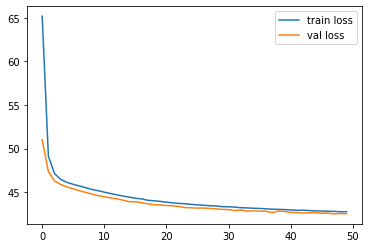

In [ ]:
def plot_losses(history):
    losses = history.history
    plt.plot(losses['loss'], label='train loss')
    plt.plot(losses['val_loss'], label='val loss')
    plt.legend()
    plt.show()

plot_losses(history)

## Results

Reconstruct the test images, plot 10 of them. Beta = 1

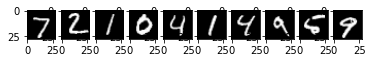

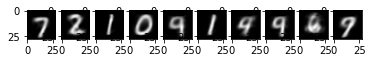

In [ ]:
decoded_images = vae.predict(X_test)

def plot_orig_and_rec(orig_images, decoded_images, n_images):
    orig_images = orig_images[:n_images]
    decoded_images = decoded_images[:n_images]
    fig = plt.figure()
    for i in range(n_images):
        fig.add_subplot(1, n_images, i+1)
        plt.imshow(orig_images[i].reshape(28,28), cmap='gray')
    plt.show()
    fig = plt.figure()
    for i in range(n_images):
        fig.add_subplot(1, n_images, i+1)
        plt.imshow(decoded_images[i].reshape(28,28), cmap='gray')
    plt.show()

plot_orig_and_rec(X_test, decoded_images, n_images=10)


Reconstruct the test images, plot 10 of them. Beta = 2

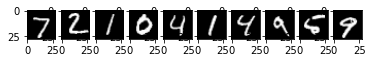

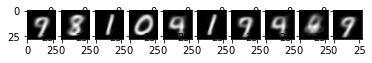

In [ ]:
decoded_images = vae.predict(X_test)

def plot_orig_and_rec(orig_images, decoded_images, n_images):
    orig_images = orig_images[:n_images]
    decoded_images = decoded_images[:n_images]
    fig = plt.figure()
    for i in range(n_images):
        fig.add_subplot(1, n_images, i+1)
        plt.imshow(orig_images[i].reshape(28,28), cmap='gray')
    plt.show()
    fig = plt.figure()
    for i in range(n_images):
        fig.add_subplot(1, n_images, i+1)
        plt.imshow(decoded_images[i].reshape(28,28), cmap='gray')
    plt.show()

plot_orig_and_rec(X_test, decoded_images, n_images=10)


Reconstruct the test images, plot 10 of them. Beta = 4

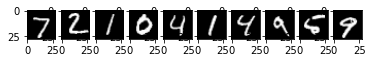

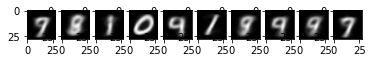

In [ ]:
decoded_images = vae.predict(X_test)

def plot_orig_and_rec(orig_images, decoded_images, n_images):
    orig_images = orig_images[:n_images]
    decoded_images = decoded_images[:n_images]
    fig = plt.figure()
    for i in range(n_images):
        fig.add_subplot(1, n_images, i+1)
        plt.imshow(orig_images[i].reshape(28,28), cmap='gray')
    plt.show()
    fig = plt.figure()
    for i in range(n_images):
        fig.add_subplot(1, n_images, i+1)
        plt.imshow(decoded_images[i].reshape(28,28), cmap='gray')
    plt.show()

plot_orig_and_rec(X_test, decoded_images, n_images=10)


Reconstruct the test images, plot 10 of them. Beta = 6

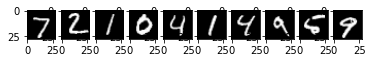

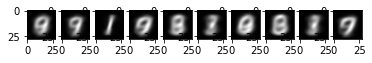

In [ ]:
decoded_images = vae.predict(X_test)

def plot_orig_and_rec(orig_images, decoded_images, n_images):
    orig_images = orig_images[:n_images]
    decoded_images = decoded_images[:n_images]
    fig = plt.figure()
    for i in range(n_images):
        fig.add_subplot(1, n_images, i+1)
        plt.imshow(orig_images[i].reshape(28,28), cmap='gray')
    plt.show()
    fig = plt.figure()
    for i in range(n_images):
        fig.add_subplot(1, n_images, i+1)
        plt.imshow(decoded_images[i].reshape(28,28), cmap='gray')
    plt.show()

plot_orig_and_rec(X_test, decoded_images, n_images=10)


Visualize the latent space. Beta = 1.

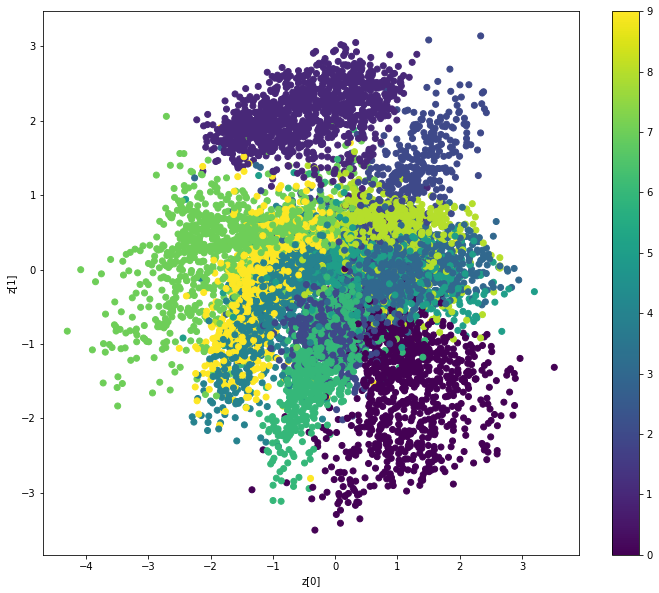

In [ ]:
z_mean, _, _ = encoder.predict(X_test)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

Visualize the latent space. Beta = 2.

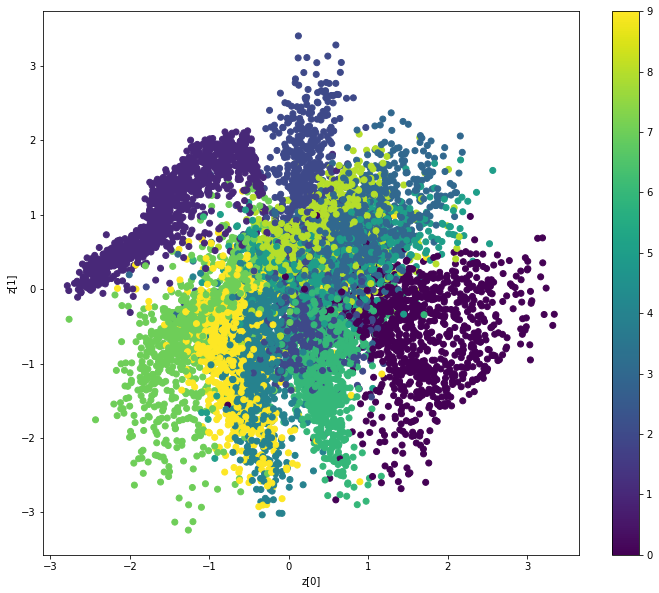

In [ ]:
z_mean, _, _ = encoder.predict(X_test)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

Visualize the latent space. Beta = 4.

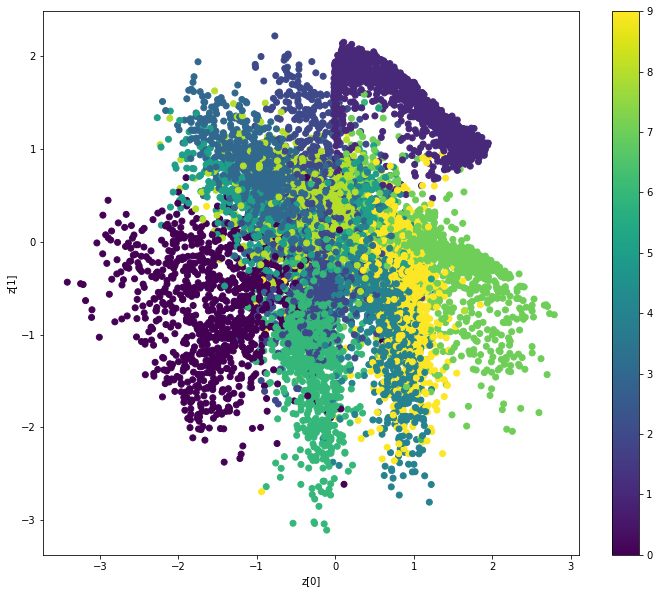

In [ ]:
z_mean, _, _ = encoder.predict(X_test)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

Visualize the latent space. Beta = 6.

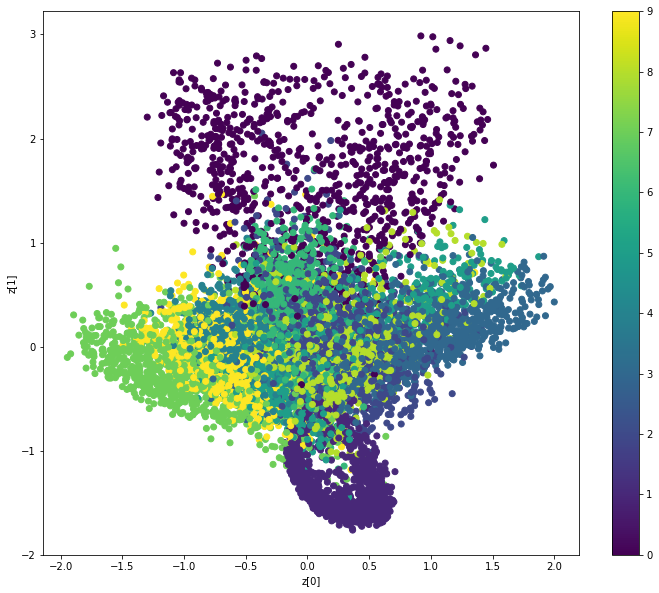

In [ ]:
z_mean, _, _ = encoder.predict(X_test)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

Display a 2D manifold of the digits. It will show how digits transform from one to the other throughout the space. Beta = 1.

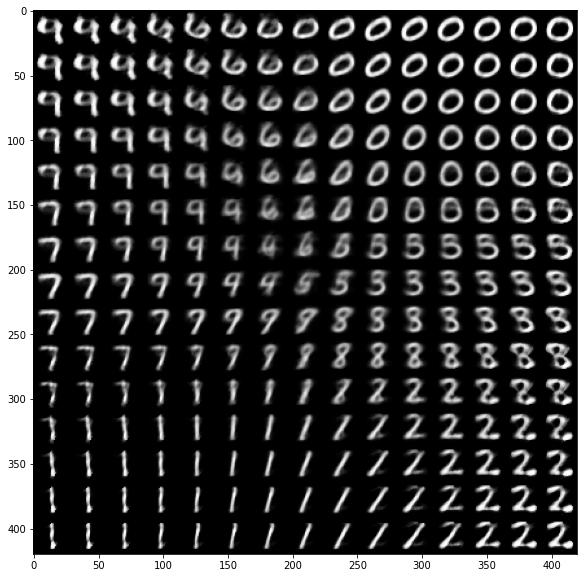

In [ ]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-3, 3] standard deviations
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()

Display a 2D manifold of the digits. It will show how digits transform from one to the other throughout the space. Beta = 2.

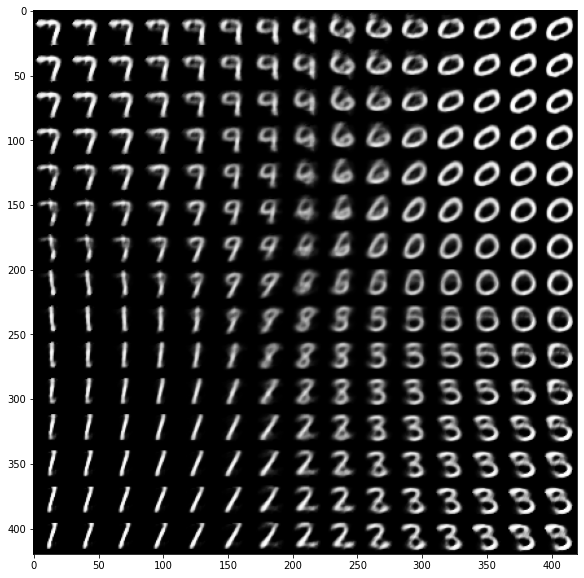

In [ ]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-3, 3] standard deviations
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()

Display a 2D manifold of the digits. It will show how digits transform from one to the other throughout the space. Beta = 4.

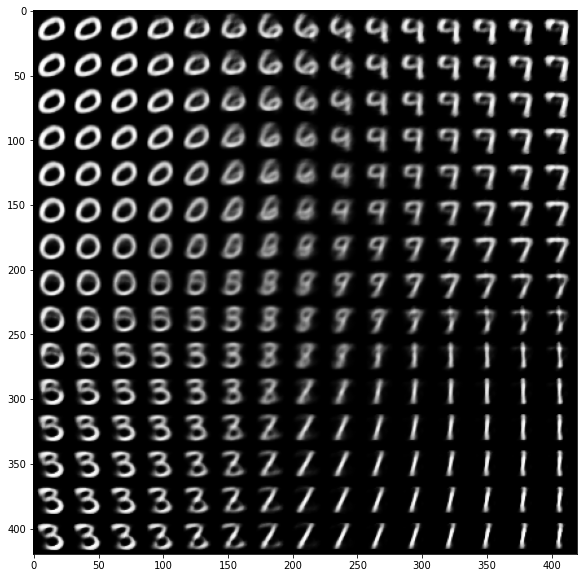

In [ ]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-3, 3] standard deviations
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()

Display a 2D manifold of the digits. It will show how digits transform from one to the other throughout the space. Beta = 6.

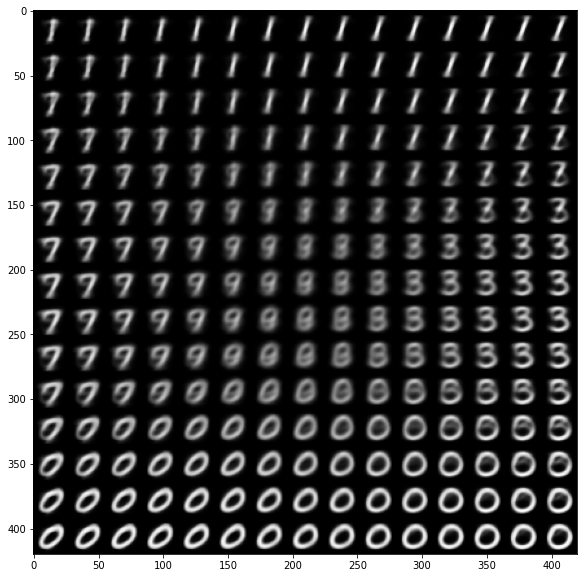

In [ ]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-3, 3] standard deviations
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()